
# Visualizer For Steady-state Visual Evoked Potentials (SSVEP) Brain-Computer Interfaces (BCI)



#### Brain Computer Interfaces (BCIs)
Brain-computer interfaces (BCIs) provide a direct pathway between the human brain and an external device, and can be especially useful for people with severe disabilities. A BCI can bypass the damaged pathways in order to provide the user with the ability to communicate or interact effectively with their surroundings. BCIs provide novel possibilities for neurorehabilitation for people with neurological disease such as stroke, amyotrophic lateral sclerosis (ALS) or paralysis.

There are two types of BCIs: endogenous and exogenous BCIs. Endogenous BCIs allows the user to voluntarily modulate
his/her neuronal activity based on intention. For example: Motor Imagery (MI BCI) – the user imagines a motor
movement such as moving the right hand/left hand or imagines lifting up the ankle (ankle
dorsiflexion). Exogenous BCIs are based on responses elicited due to an external stimulus. These responses are generated when the user focuses his/her attention on a stimulus which is associated with a BCI command. Examples include P300 BCI, steady-state visual evoked potentials (SSVEP) based BCIs, steady-state motion visual evoked potential (SSMVEP) BCIs, etc. 


#### Steady-state Visual evoked Potentials (SSVEP) based BCI

Steady-state visual evoked potentials are responses elicited when a user focuses his/her attention on a repetitive visual stimulus (a light source) flickering at frequencies higher than 6 Hz. These are periodic responses prominently observed in the occipital and occipito-parietal areas of the cortex. SSVEP responses appear as an increase in the amplitude of the signal at the fundamental frequency and its harmonics for the corresponding stimulus attended by the user. Therefore, by analyzing the dominant frequency response in the EEG, the stimulus attended to by the user can be identified. 

Video: https://youtu.be/cd4m2flXS2U

The work in this notebook is based of off the work from Aravind Ravi's Repository found here: https://github.com/aaravindravi/Brain-computer-interfaces


In [34]:
%%capture
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io as sio
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt

In [35]:
def butter_bandpass_filter(data, lowcut, highcut, sample_rate, order):
    '''
    Returns bandpass filtered data between the frequency ranges specified in the input.
    Args:
        data (numpy.ndarray): array of samples. 
        lowcut (float): lower cutoff frequency (Hz).
        highcut (float): lower cutoff frequency (Hz).
        sample_rate (float): sampling rate (Hz).
        order (int): order of the bandpass filter.
    Returns:
        (numpy.ndarray): bandpass filtered data.
    '''
    
    nyq = 0.5 * sample_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

In [36]:
#no overlapping buffer, were keeping it simple for now (ask aravind later)
def get_filtered_eeg(eeg, lowcut, highcut, order, sample_rate):
    '''
    Returns bandpass filtered eeg for all channels and trials.
    Args:
        eeg (numpy.ndarray): raw eeg data of shape (num_classes, num_channels, num_samples, num_trials).
        lowcut (float): lower cutoff frequency (Hz).
        highcut (float): lower cutoff frequency (Hz).
        order (int): order of the bandpass filter.
        sample_rate (float): sampling rate (Hz).
    Returns:
        (numpy.ndarray): bandpass filtered eeg of shape (num_classes, num_channels, num_samples, num_trials).
    '''
    
    num_classes = eeg.shape[0]
    num_chan = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]

    #instantiate object to be sent to BP filter
    filtered_data = np.zeros((eeg.shape[0], eeg.shape[1], total_trial_len, eeg.shape[3]))

    
    for target in range(0, num_classes):
        for channel in range(0, num_chan):
            for trial in range(0, num_trials):
                
                #data to be filtered
                signal_to_filter = np.squeeze( eeg[target, channel, 0:total_trial_len, trial] )
                
                #call to BP filter
                filtered_data[target, channel, :, trial] = butter_bandpass_filter(signal_to_filter, 
                                                                                  lowcut, highcut, 
                                                                                  sample_rate, order)
                
    return filtered_data

In [37]:
def buffer(data, duration, data_overlap):
    '''
    Returns segmented data based on the provided input window duration and overlap.
    Args:
        data (numpy.ndarray): array of samples. 
        duration (int): window length (number of samples).
        data_overlap (int): number of samples of overlap.
    Returns:
        (numpy.ndarray): segmented data of shape (number_of_segments, duration).
    '''
    
    number_segments = int(np.ceil((len(data) - data_overlap)/(duration - data_overlap)))
    temp_buf = [data[i:i+duration] for i in range(0, len(data), (duration - int(data_overlap)))]
    temp_buf[number_segments-1] = np.pad(temp_buf[number_segments-1],
                                         (0, duration-temp_buf[number_segments-1].shape[0]),
                                         'constant')
    segmented_data = np.vstack(temp_buf[0:number_segments])
    
    return segmented_data

In [38]:
def get_segmented_epochs(data, window_len, shift_len, sample_rate):
    '''
    Returns epoched eeg data based on the window duration and step size.
    Args:
        data (numpy.ndarray): array of samples. 
        window_len (int): window length (seconds).
        shift_len (int): step size (seconds).
        sample_rate (float): sampling rate (Hz).
    Returns:
        (numpy.ndarray): epoched eeg data of shape. 
        (num_classes, num_channels, num_trials, number_of_segments, duration).
    '''
    
    num_classes = data.shape[0]
    num_chan = data.shape[1]
    num_trials = data.shape[3]
    
    duration = int(window_len*sample_rate)
    data_overlap = (window_len - shift_len)*sample_rate
    
    number_of_segments = int(np.ceil((data.shape[2] - data_overlap)/
                                       (duration - data_overlap)))
    
    segmented_data = np.zeros((data.shape[0], data.shape[1], 
                               data.shape[3], number_of_segments, duration))

    for target in range(0, num_classes):
        for channel in range(0, num_chan):
            for trial in range(0, num_trials):
                segmented_data[target, channel, trial, :, :] = buffer(data[target, channel, :, trial], 
                                                                      duration, data_overlap) 
    
    return segmented_data

In [39]:
def magnitude_spectrum_features(segmented_data, FFT_PARAMS):
    '''
    Returns magnitude spectrum features. Fast Fourier Transform computed based on
    the FFT parameters provided as input.
    Args:
        segmented_data (numpy.ndarray): epoched eeg data of shape 
        (num_classes, num_channels, num_trials, number_of_segments, num_samples).
        FFT_PARAMS (dict): dictionary of parameters used for feature extraction.
        FFT_PARAMS['resolution'] (float): frequency resolution per bin (Hz).
        FFT_PARAMS['start_frequency'] (float): start frequency component to pick from (Hz). 
        FFT_PARAMS['end_frequency'] (float): end frequency component to pick upto (Hz). 
        FFT_PARAMS['sampling_rate'] (float): sampling rate (Hz).
    Returns:
        (numpy.ndarray): magnitude spectrum features of the input EEG.
        (n_fc, num_channels, num_classes, num_trials, number_of_segments).
    '''
    
    num_classes = segmented_data.shape[0]
    num_chan = segmented_data.shape[1]
    num_trials = segmented_data.shape[2]
    number_of_segments = segmented_data.shape[3]
    fft_len = segmented_data[0, 0, 0, 0, :].shape[0]

    NFFT = round(FFT_PARAMS['sampling_rate']/FFT_PARAMS['resolution'])
    fft_index_start = int(round(FFT_PARAMS['start_frequency']/FFT_PARAMS['resolution']))
    fft_index_end = int(round(FFT_PARAMS['end_frequency']/FFT_PARAMS['resolution']))+1

    features_data = np.zeros(((fft_index_end - fft_index_start), 
                              segmented_data.shape[1], segmented_data.shape[0], 
                              segmented_data.shape[2], segmented_data.shape[3]))
    
    for target in range(0, num_classes):
        for channel in range(0, num_chan):
            for trial in range(0, num_trials):
                for segment in range(0, number_of_segments):
                    temp_FFT = np.fft.fft(segmented_data[target, channel, trial, segment, :], NFFT)/fft_len
                    magnitude_spectrum = 2*np.abs(temp_FFT)
                    features_data[:, channel, target, trial, segment] = magnitude_spectrum[fft_index_start:fft_index_end,]
    
    return features_data

In [40]:
def complex_spectrum_features(segmented_data, FFT_PARAMS):
    '''
    Returns complex spectrum features. Fast Fourier Transform computed based on
    the FFT parameters provided as input. The real and imaginary parts of the input
    signal are concatenated into a single feature vector.
    Args:
        segmented_data (numpy.ndarray): epoched eeg data of shape 
        (num_classes, num_channels, num_trials, number_of_segments, num_samples).
        FFT_PARAMS (dict): dictionary of parameters used for feature extraction.
        FFT_PARAMS['resolution'] (float): frequency resolution per bin (Hz).
        FFT_PARAMS['start_frequency'] (float): start frequency component to pick from (Hz). 
        FFT_PARAMS['end_frequency'] (float): end frequency component to pick upto (Hz). 
        FFT_PARAMS['sampling_rate'] (float): sampling rate (Hz).
    Returns:
        (numpy.ndarray): complex spectrum features of the input EEG.
        (2*n_fc, num_channels, num_classes, num_trials, number_of_segments)
    '''
    
    num_classes = segmented_data.shape[0]
    num_chan = segmented_data.shape[1]
    num_trials = segmented_data.shape[2]
    number_of_segments = segmented_data.shape[3]
    fft_len = segmented_data[0, 0, 0, 0, :].shape[0]

    NFFT = round(FFT_PARAMS['sampling_rate']/FFT_PARAMS['resolution'])
    fft_index_start = int(round(FFT_PARAMS['start_frequency']/FFT_PARAMS['resolution']))
    fft_index_end = int(round(FFT_PARAMS['end_frequency']/FFT_PARAMS['resolution']))+1

    features_data = np.zeros((2*(fft_index_end - fft_index_start), 
                              segmented_data.shape[1], segmented_data.shape[0], 
                              segmented_data.shape[2], segmented_data.shape[3]))
    
    for target in range(0, num_classes):
        for channel in range(0, num_chan):
            for trial in range(0, num_trials):
                for segment in range(0, number_of_segments):
                    temp_FFT = np.fft.fft(segmented_data[target, channel, trial, segment, :], NFFT)/fft_len
                    real_part = np.real(temp_FFT)
                    imag_part = np.imag(temp_FFT)
                    features_data[:, channel, target, trial, segment] = np.concatenate((
                        real_part[fft_index_start:fft_index_end,], 
                        imag_part[fft_index_start:fft_index_end,]), axis=0)
    
    return features_data

In [41]:
# Setting up some completely fixed parameters
FFT_PARAMS = {
    'resolution': 0.2930,
    'start_frequency': 0.0,
    'end_frequency': 35.0,
    'sampling_rate': 250
}
magnitude_spectrum = dict()

#window and shift in time (seconds)

#left at 4.4s by default for no overlapping segments, only one segment
window_len = 4.4
shift_len = 4.4

sample_rate = FFT_PARAMS['sampling_rate']

# Load the Data Set
Load the dataset and compute the magnitude spectrum for every trial

In [42]:
#REPLACE CSV NAME WITH CSV OF INTEREST
csvname = '264_2022_015918'

path = os.path.split(os.getcwd())[0] + '/ODC-DEMO/demo_data/' + csvname + '.csv'

df = pd.read_csv (path)

In [43]:
# Establishing what flicker frequencies are present
flicker_freq_dict = dict()

# Adding row keys of relevant frequencies from dataframe 
for i, freq_point in enumerate(df['Frequency']):
    if not np.isnan(freq_point) and not freq_point == 0:
        if freq_point not in flicker_freq_dict.keys():
            flicker_freq_dict.update({freq_point: [i]})
        else:
            flicker_freq_dict[freq_point].append(i)
flicker_freq = np.array(list(flicker_freq_dict.keys()))

In [44]:

#USE THIS TO SEE IF MARKER PLACEMENT WAS DELAYED, THIS IS ONLY USED FOR TESTING, OTHERWISE LEAVE OFFST = 0

# offst  = 0
# for i in range(len(flicker_freq_dict[9.25])):
#     flicker_freq_dict[9.25][i] = flicker_freq_dict[9.25][i] + offst
#     flicker_freq_dict[11.25][i] = flicker_freq_dict[11.25][i] + offst
#     flicker_freq_dict[13.25][i] = flicker_freq_dict[13.25][i] + offst
#     flicker_freq_dict[9.75][i] = flicker_freq_dict[9.75][i] + offst
#     flicker_freq_dict[11.75][i] = flicker_freq_dict[11.75][i] + offst
#     flicker_freq_dict[13.75][i] = flicker_freq_dict[13.75][i] + offst
#     flicker_freq_dict[10.25][i] = flicker_freq_dict[10.25][i] + offst
#     flicker_freq_dict[12.25][i] = flicker_freq_dict[12.25][i] + offst
#     flicker_freq_dict[14.25][i] = flicker_freq_dict[14.25][i] + offst
#     flicker_freq_dict[10.75][i] = flicker_freq_dict[10.75][i] + offst
#     flicker_freq_dict[12.75][i] = flicker_freq_dict[12.75][i] + offst
#     flicker_freq_dict[14.75][i] = flicker_freq_dict[14.75][i] + offst

In [45]:
# Formatting the eeg data -> making the appropriate matrix
# Initializing the dimensions of the eeg matrix

num_classes = len(flicker_freq) 
n_ch = 8 
total_trial_len = 1100 

#scales to number of trials in csv for each freq
num_trials = min(len(flicker_freq_dict[key]) for key in flicker_freq)

#instantiates eeg data in 4 dimensional np array
eeg = np.zeros((num_classes,n_ch,total_trial_len,num_trials))

# Assigning the correct values to the matrix/object

start_idx_list = []


#grabs start and endpoints for each frequency flash
for i, freq in enumerate(flicker_freq):
    for j in range(num_trials):
        start_idx = flicker_freq_dict[freq][j]
        start_idx_list.append(start_idx)
        end_idx = start_idx + total_trial_len
        
        #shaves off timestamps and markers and does a transpose, we transpose it back and cast as a np array
        eeg[i, :, :, j] = np.array(df.iloc[start_idx:end_idx, 1:9]).transpose((1,0))

#wrapper function for EEG data filtering with 4th order BP
filtered_data = get_filtered_eeg(eeg, 7, 17, 4, sample_rate)



segmented_data = get_segmented_epochs(filtered_data, window_len, shift_len, sample_rate)



magnitude_spectrum = magnitude_spectrum_features(segmented_data, FFT_PARAMS)


# Frequency Response calculated using Fast-Fourier Transform (FFT)

In [46]:
%matplotlib inline

In [49]:
def plot_spectrum(ax, magnitude_spectrum, resolution, num_classes, channel, flicker_freq, title=None):
    
    for target in range(num_classes):
        
        fft_axis = np.arange(magnitude_spectrum.shape[0])*resolution
        
        ax[target].plot(fft_axis, np.mean(np.squeeze(magnitude_spectrum[:, channel, target, :, :]), 
                                          axis=1))
        
        #ax[target].plot(fft_axis, np.squeeze(magnitude_spectrum[:, channel, target, :, :]))
        ax[target].set_xlabel('Frequency (Hz)') 
        ax[target].set_ylabel('Amplitude (uV)')
        if title:
            ax[target].set_title(f' freq. {flicker_freq[target]} Hz Ch: {title}')
        else:
            ax[target].set_title(f' freq. {flicker_freq[target]} Hz')
        ax[target].set_xlim([8,16])
    plt.show()


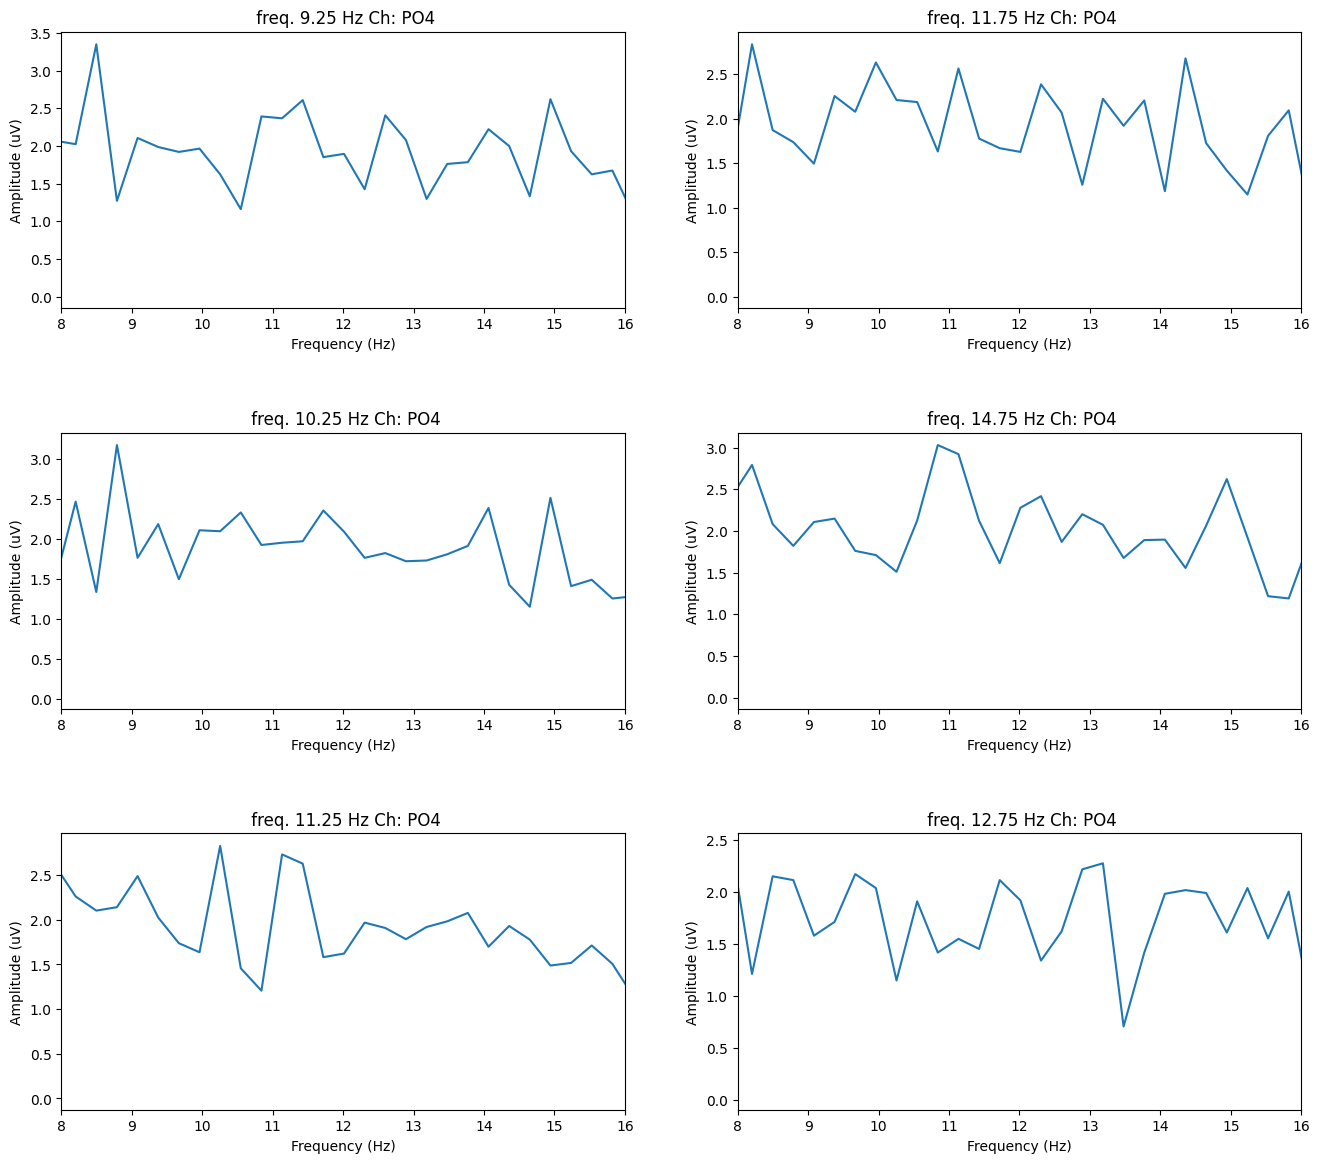

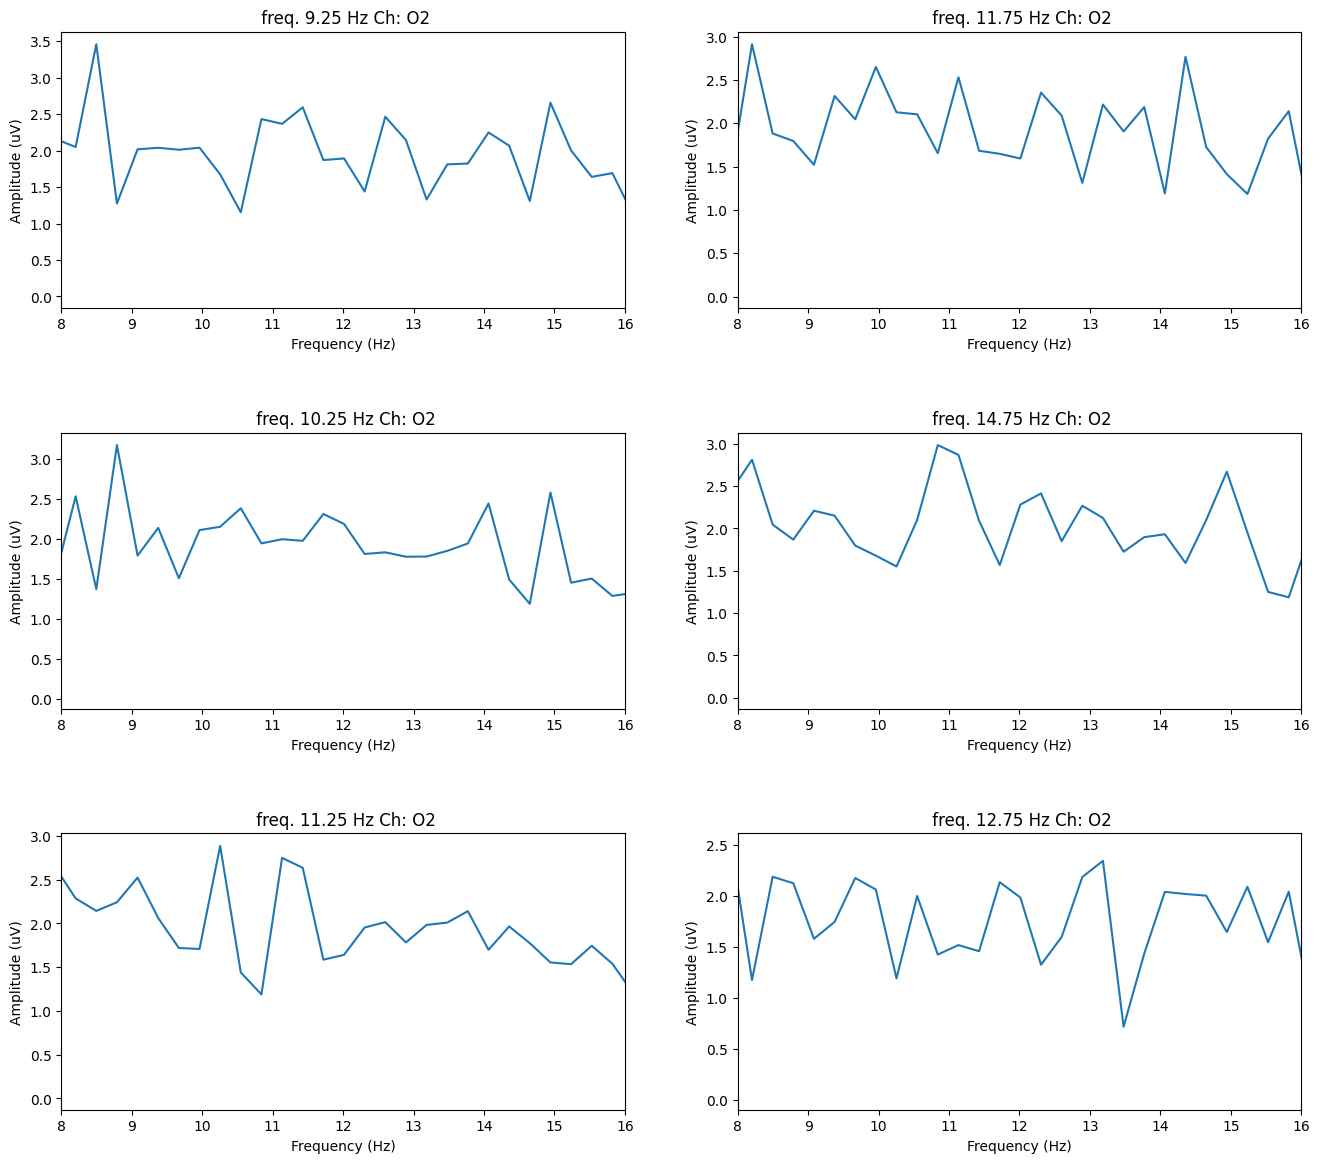

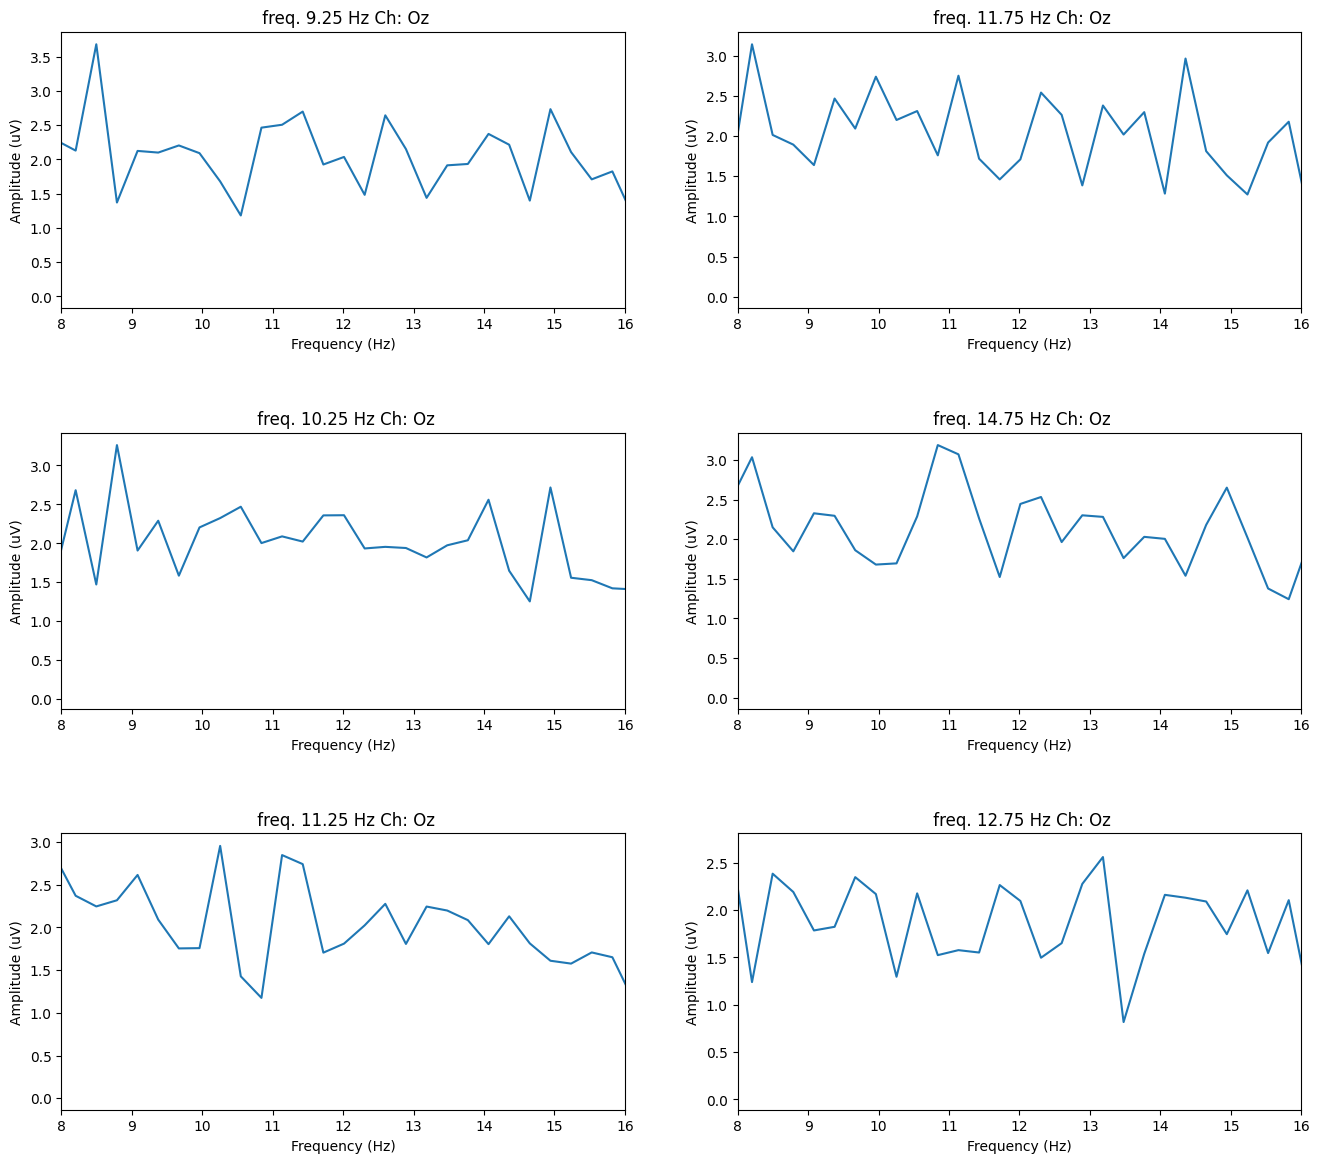

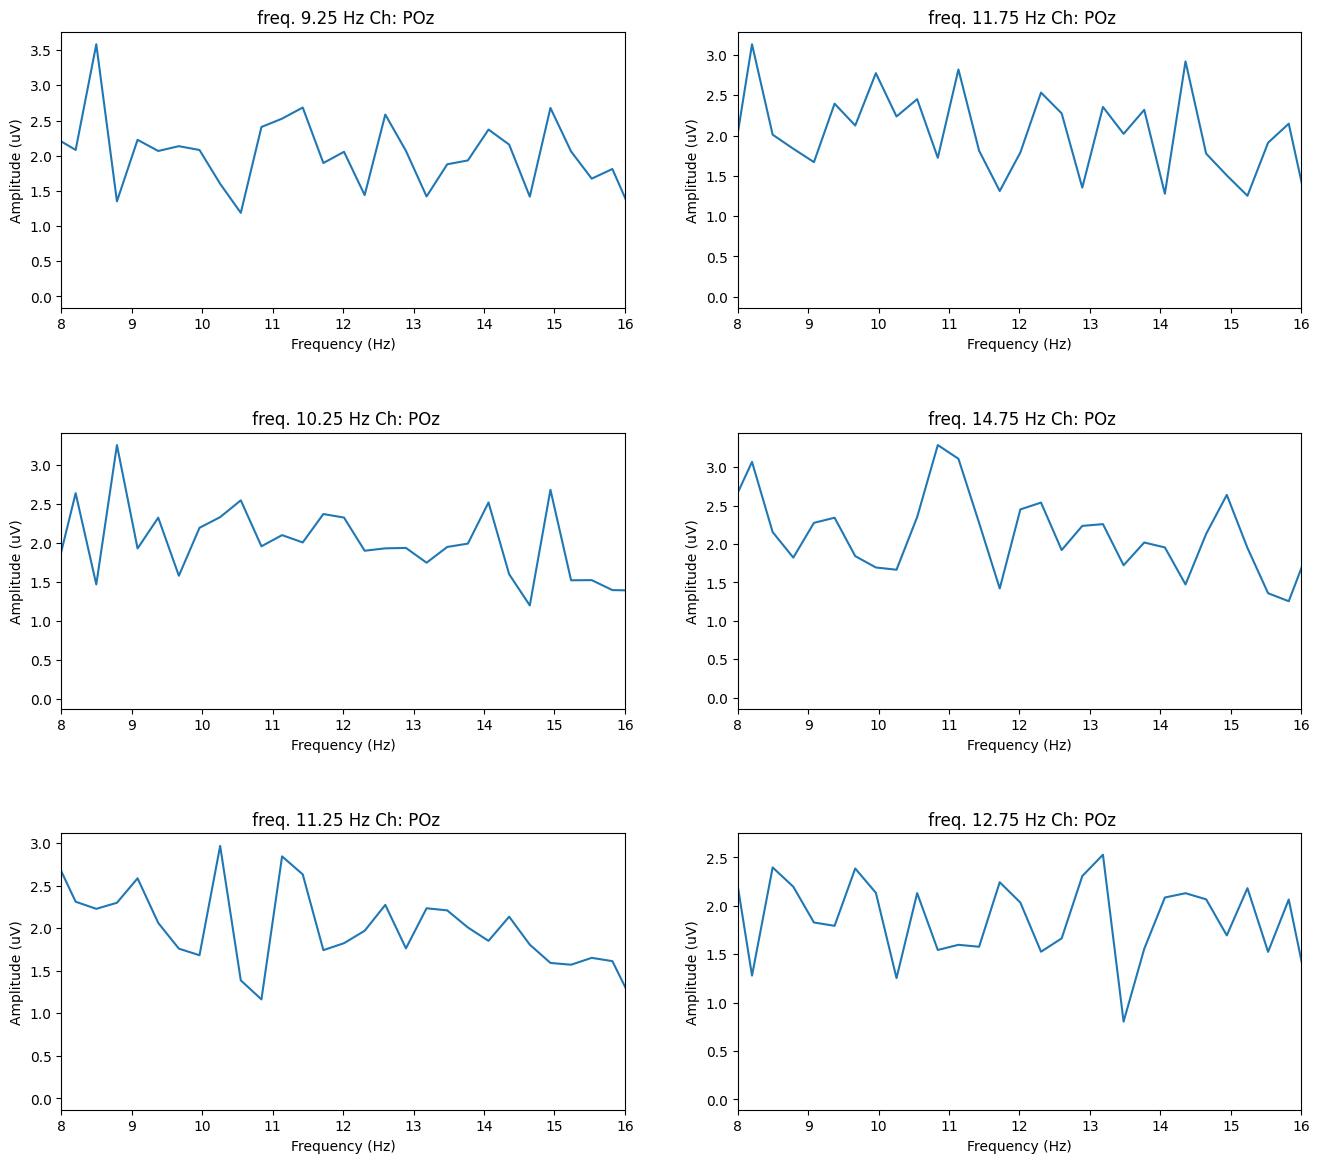

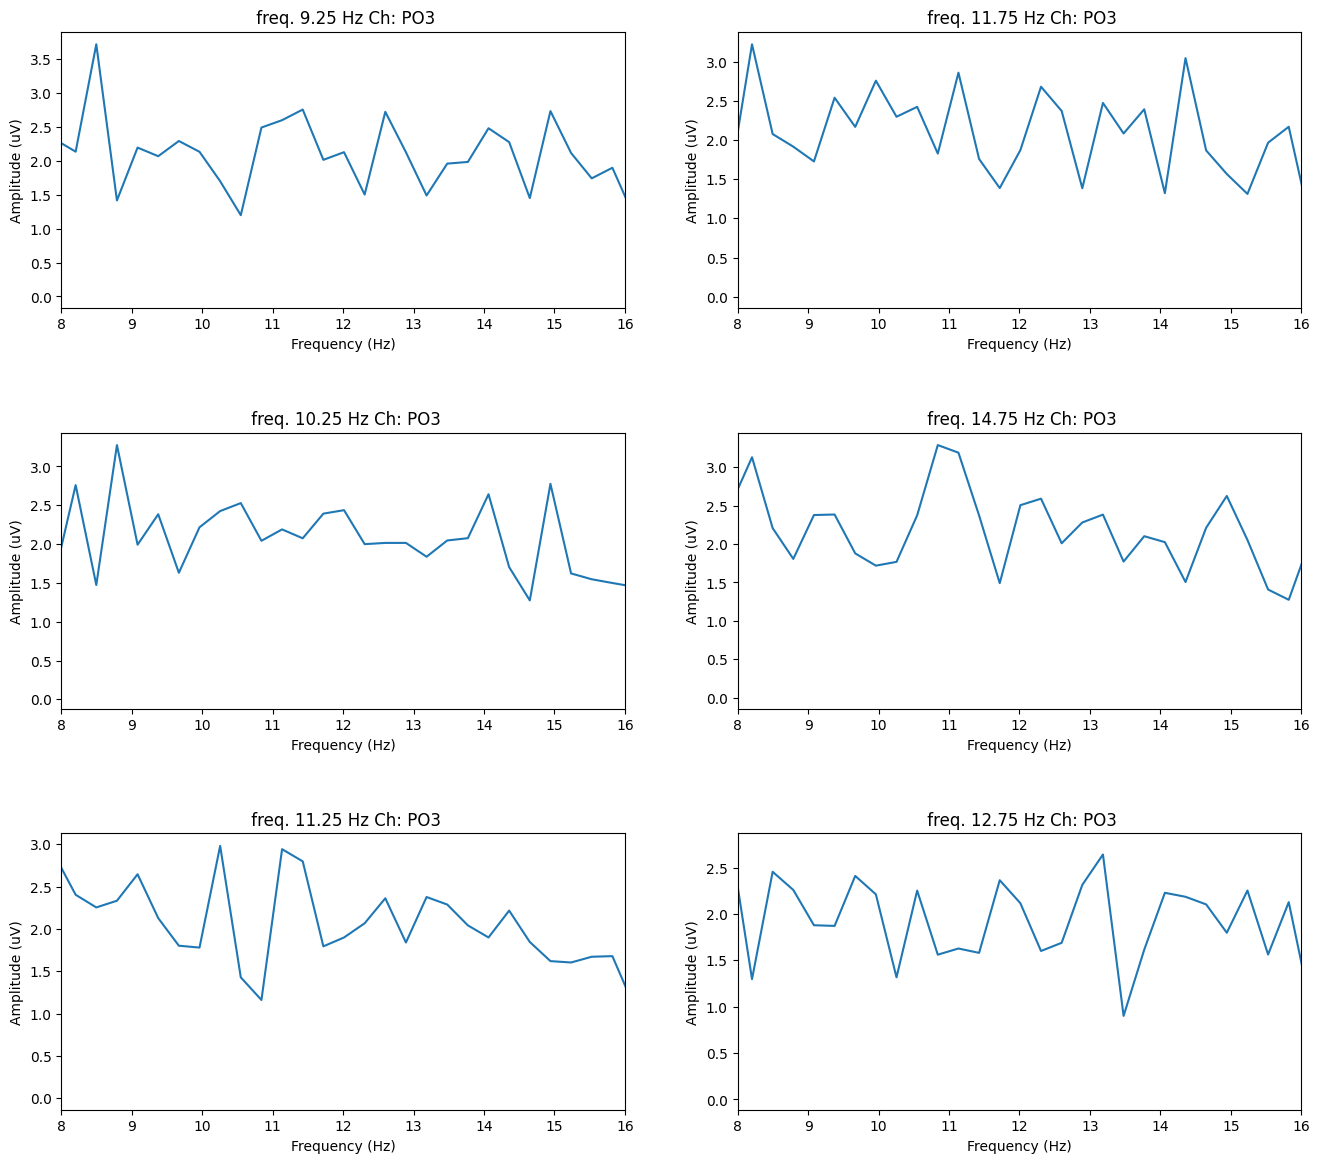

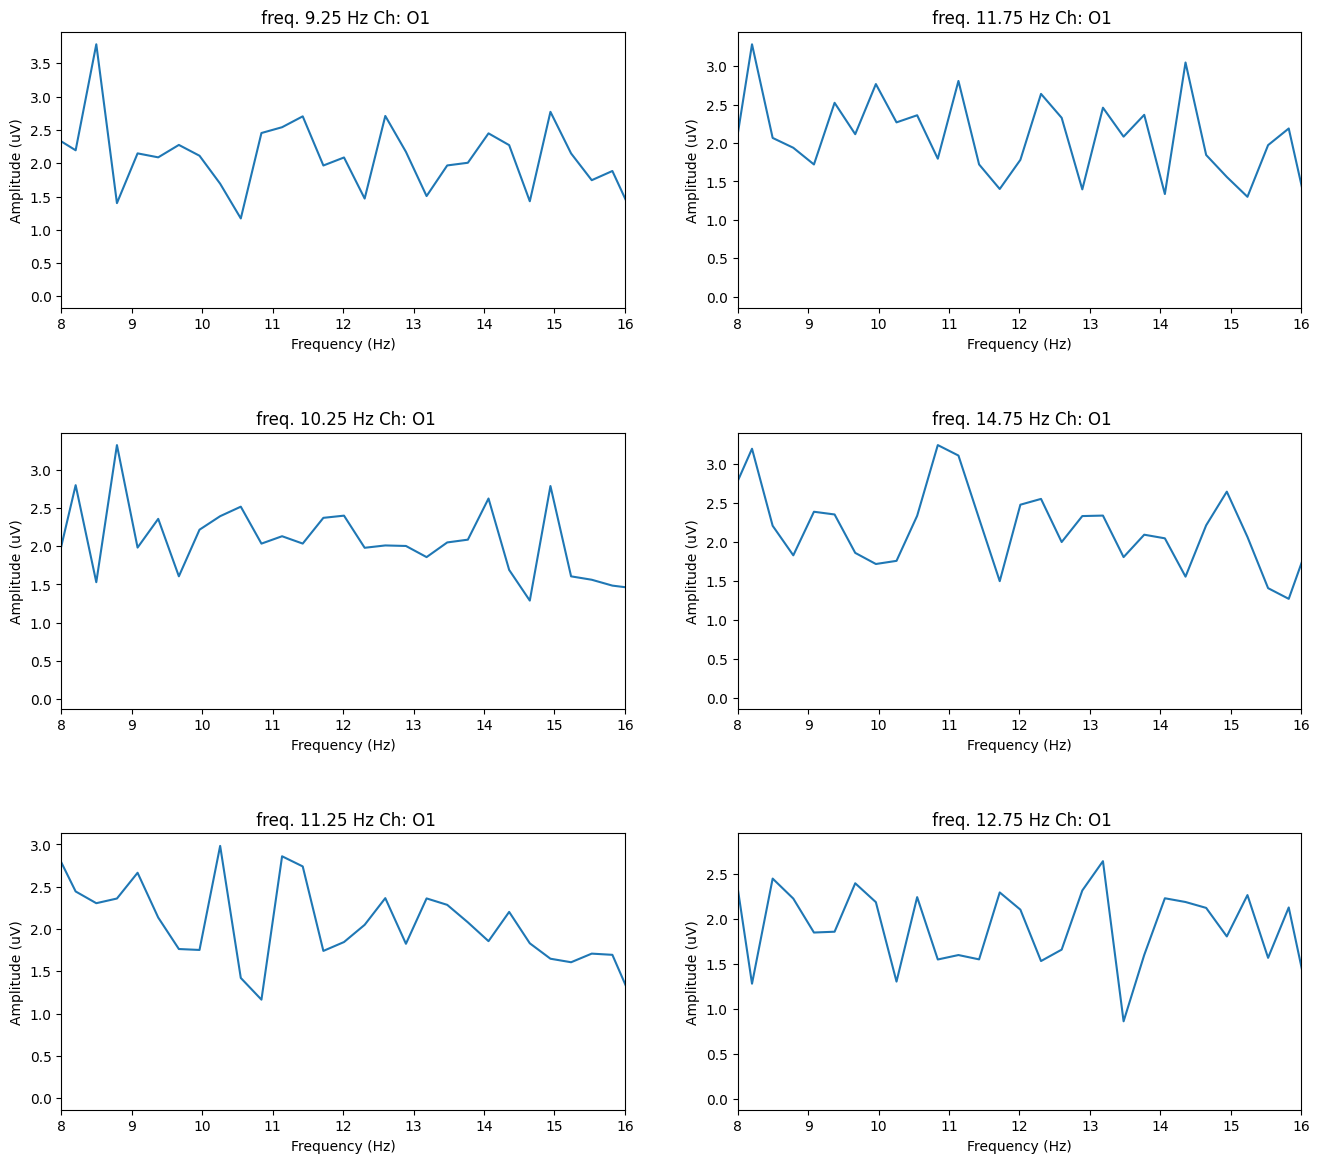

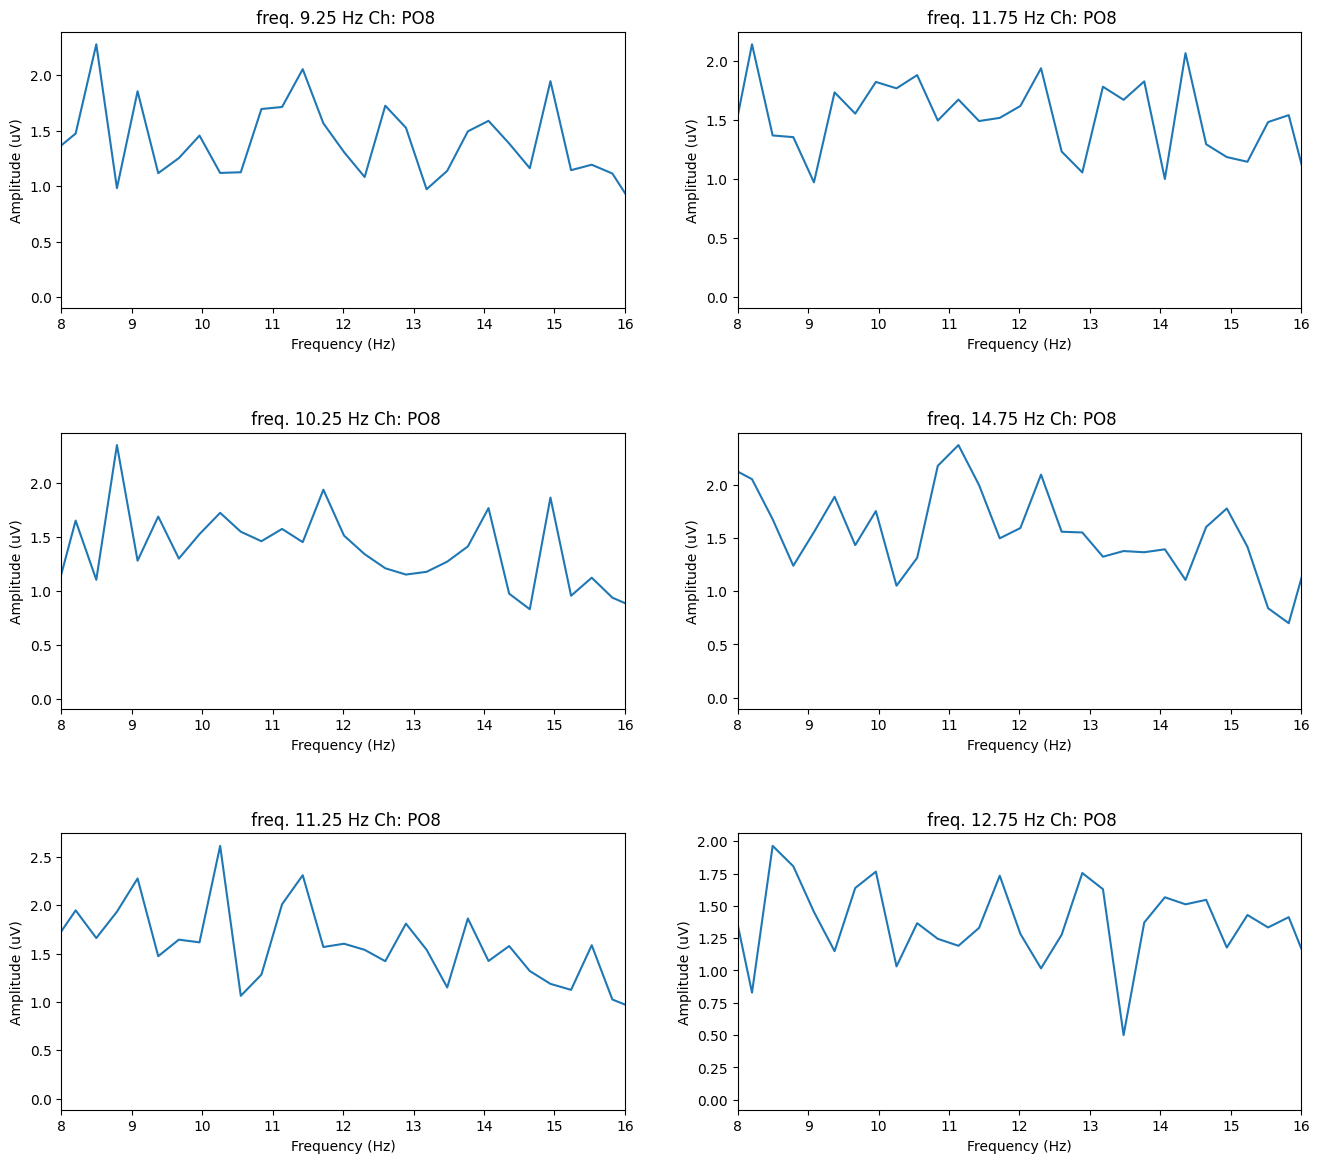

In [50]:
# ELECTRODE LOCATIONS (10 20 diagram) BASED ON CHANNEL 
channel_list = ['PO4', 'O2', 'Oz', 'POz', 'PO3', 'O1', 'PO8', 'PO7']

# PLOT FFT RESPONSE
for channel in range(7):
    #if 6 stim change first param to 3, if 8 stim change first param to 4
    fig, axes = plt.subplots(2, 2,figsize=(16, 14), gridspec_kw=dict(hspace=0.45, wspace=0.2))
    axes = axes.reshape(-1)
    plot_spectrum(axes, magnitude_spectrum, FFT_PARAMS['resolution'], num_classes,
                  channel, flicker_freq, title=channel_list[channel])